<a href="https://colab.research.google.com/github/tamucc-gcl/wrkshp_edna_metabarcoding/blob/main/analysis/alpha_diversity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alpha Diversity Analysis




---
## Initialize Environment

In [2]:
#Set-up Computing Environment - Python

## Mount Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.environ['COLAB'] = 'TRUE'

## Install Linux programs needed
!apt install libfribidi-dev libglpk-dev libharfbuzz-dev pandoc

## Clone GitHub Repo and move into that repo
local_path = '/content/edna_workshop'
repo  = "tamucc-gcl/wrkshp_edna_metabarcoding"
url = f"https://github.com/{repo}.git"
!git clone {url} {local_path}

## Setup R and move to local directory
os.chdir(local_path)
%reload_ext rpy2.ipython

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3 libcolamd2
  libcxsparse3 libglpk40 libgmp-dev libgmpxx4ldbl libgraphblas-dev
  libgraphblas6 libgraphite2-dev libharfbuzz-gobject0 libharfbuzz-icu0 libklu1
  libldl2 libmetis5 libmongoose2 librbio2 libsliplu1 libspqr2
  libsuitesparse-dev libsuitesparseconfig5 libumfpack5 pandoc-data
Suggested packages:
  libiodbc2-dev gmp-doc libgmp10-doc libmpfr-dev libgraphite2-utils
  texlive-latex-recommended texlive-xetex texlive-luatex pandoc-citeproc
  texlive-latex-extra context wkhtmltopdf librsvg2-bin groff ghc nodejs php
  python ruby libjs-mathjax libjs-katex citation-style-language-styles
The following NEW packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3
  libcmark-gfm-exte

In [3]:
#Set-up Computing Environment - R
%%R -i local_path
# Point R at your Drive-backed library
drive_lib <- "/content/drive/MyDrive/edna_libraries"
dir.create(drive_lib, recursive = TRUE, showWarnings = FALSE)
.libPaths(c(drive_lib, .libPaths()))

#Install renv if it isn't already
if (!require("renv", lib.loc = drive_lib, quietly = TRUE, warn.conflicts = FALSE)) {
  install.packages("renv", lib = drive_lib,
                   quietly = TRUE, warn.conflicts = FALSE)
}

#Install required libraries into google drive if they aren't already
renv::restore(library = drive_lib,
              lockfile = paste0(local_path, '/renv.lock'),
              prompt = FALSE)

- The library is already synchronized with the lockfile.


In addition: Warning messages:
1: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
2: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
3: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
4: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
5: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
6: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory


---
## User Settings

In [4]:
%%R
min_samples_predator <- 5 #Minimum number of samples of a given predator species to keep it
MIN_NUMBER_PREDATORS_IN <- 20 #How many predators does a genus need to be in to be plotted in the stomach composition plot
inext_predator_subsample <- 5
inext_bootstraps <- 10
tree_bootstraps <- 5
tree_evolutionary_model <- 'JC'

---
## Libraries & Data

In [5]:
%%R
library(Biostrings)
library(tidyverse)
library(iNEXT)
library(phangorn)
library(picante)
library(HierDpart)
library(ade4)
library(ggnested)
library(ggtext)
library(patchwork)

source('https://raw.githubusercontent.com/tamucc-gcl/iDIP.phylo/refs/heads/main/iDIP.phylo.R')
source(str_c(here::here(), 'r_functions/fasta2tree.R', sep = '/'))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%() masks IRanges::%within%()
✖ dplyr::collapse()     masks Biostrings::collapse(), IRanges::collapse()
✖ dplyr::combine()      masks BiocGenerics::combine()
✖ purrr::compact()      masks XVector::compact()
✖ dplyr::desc()         masks IRanges::desc()
✖ tidyr::expand()       masks S4Vectors::expand()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::first()        masks S4Vectors::first()
✖ dplyr::lag()          masks stats::lag()
✖ purrr::modify()       masks renv::modify()
✖ ggplot2::Position()   masks BiocGenerics::Position(), base::Position()
✖ purrr::reduce()       masks IRanges::reduce()
✖ dplyr::rename()       mask

Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min

Loading required package: S4Vectors
Loading required package: stats4

Attaching package: ‘S4Vectors’

The following object is masked from ‘package:utils’:

    findMatches

The following objects are masked from ‘package:base’:

    expand.grid, I, unname

Loading required package: IRanges
Loading required package: XVector
Loading required package: GenomeInfoDb

Attaching package

In [6]:
%%R
storage_dir <- if_else(nzchar(Sys.getenv("COLAB")), drive_lib, here::here())
dir.create(str_c(storage_dir, 'intermediate_files', sep = '/'), showWarnings = FALSE)

predator_gut_contents <- read_csv(str_c(storage_dir,
                                        'intermediate_files/filtered_zotu_counts.csv',
                                        sep = '/'),
                                  show_col_types = FALSE)

zotu_taxonomy <- read_csv(str_c(storage_dir,
                                'intermediate_files/zotu_taxonomy.csv',
                                sep = '/'),
                          show_col_types = FALSE)

predator_taxonomy <- read_rds(str_c(storage_dir,
                                    'intermediate_files/predator_taxonomy.rds',
                                    sep = '/'))


zotu_sequences <- readDNAStringSet(str_c(here::here(),
                                         'output/rainbow_bridge/zotu_sequences.fasta',
                                         sep = '/'))
names(zotu_sequences) <- str_extract(names(zotu_sequences), 'Zotu[0-9]+')
zotu_sequences <- zotu_sequences[names(zotu_sequences) %in% colnames(predator_gut_contents)]

---
## Stomach Contents Composition

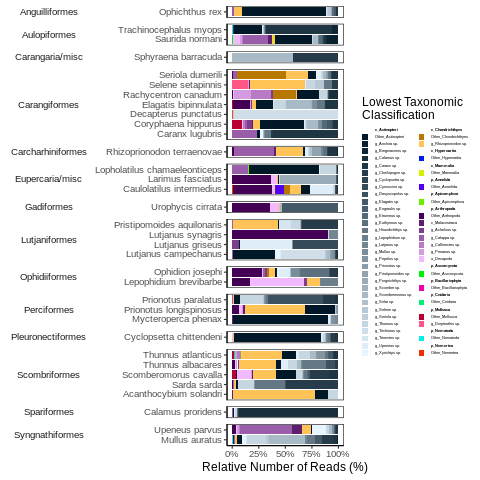

In [7]:
%%R
sample_composition <- predator_gut_contents %>%
  pivot_longer(cols = starts_with('Zotu'),
               names_to = 'zotu',
               values_to = 'n_reads') %>%
  filter(n_reads > 0) %>%
  left_join(zotu_taxonomy,
            by = 'zotu') %>%
  mutate(across(where(is.character),
                ~if_else(. == 'LCA_dropped', NA_character_, .))) %>%

  #Skip genus & species for the sake of the legend
  mutate(lowest_level = case_when(#!is.na(species) ~ str_c('s_', species),
                                  !is.na(genus) ~ str_c('g_', genus, ' sp.'),
                                  !is.na(family) ~ str_c('f_', family),
                                  !is.na(order) ~ str_c('o_', order),
                                  !is.na(class) ~ str_c('c_', class),
                                  !is.na(phylum) ~ str_c('p_', phylum),
                                  !is.na(kingdom) ~ str_c('k_', kingdom),
                                  !is.na(domain) ~ str_c('d_', domain),
                                  TRUE ~ 'Unknown'),
         upper_level = case_when(phylum == 'Chordata' & !taxid_rank %in% c('domain', 'kingdom', 'phylum') ~ str_c('c_', class),
                                 TRUE ~ str_c('p_', phylum)),
         .after = species) %>%

  summarise(n_reads = sum(n_reads),
            zotu = unique(zotu) %>% str_c(collapse = '; '),
            .by = c(predator_species_name, upper_level, lowest_level)) %>%

  #Lump together for the sake of the legend/interpretabilitu
  mutate(lowest_level = fct_lump_min(lowest_level, min = MIN_NUMBER_PREDATORS_IN),
         lowest_level = if_else(lowest_level == 'Other',
                                str_c(lowest_level, str_remove(upper_level, '._'), sep = '_'),
                                lowest_level)) %>%
  select(-zotu) %>%
  summarise(n_reads = sum(n_reads),
            .by = where(is.character))

sample_composition %>%
  left_join(predator_taxonomy,
            by = c('predator_species_name' = 'species')) %>%
  ggnested(aes(y = predator_species_name, x = n_reads,
               main_group = upper_level, sub_group = lowest_level),
           legend_labeling = 'sub', legend_title = 'Lowest Taxonomic\nClassification',
           main_keys = TRUE, nested_aes = c("fill"),
           gradient_type = 'both') +
  geom_col(position = 'fill') +
  scale_x_continuous(labels = scales::percent_format()) +
  guides(fill = guide_legend(ncol = 2)) + #ncol = 5
  facet_grid(order ~ ., scales = 'free_y', space = 'free_y', switch = 'y') +
  labs(y = NULL,
       x = 'Relative Number of Reads (%)') +
  theme_classic(base_size = 12) +
  theme(axis.title.x = element_markdown(),
        axis.title.y = element_markdown(),
        panel.background = element_rect(colour = 'black'),
        legend.position = 'right',
        legend.text = element_markdown(size = 4),
        legend.key = element_blank(),
        legend.key.size = unit(0.5, "line"),
        strip.text.y.left = element_text(angle = 0),
        strip.background = element_blank(),
        strip.placement = "outside")

---
## Using iNEXT to determine alpha diversity


1.   Account for sampling depth
2.   Modern improvements to rarifaction ##TODO - In progress



In [8]:
%%R
endpoint_reads <- predator_gut_contents %>%
  filter(n() >= min_samples_predator,
         .by = predator_species_name) %>%
  pivot_longer(cols = starts_with('Zotu'),
               names_to = 'zotu',
               values_to = 'n_reads') %>%
  summarise(n_reads = sum(n_reads),
            .by = sample_id) %>%
  summarise(mean_reads = mean(n_reads),
            median_reads = median(n_reads)) %>%
  pull(mean_reads) %>%
  floor()

if(!file.exists(str_c(here::here(),
                      'intermediate_files/inext_out.rds',
                      sep = '/'))){
  inext_out <- predator_gut_contents %>%

    filter(n() >= min_samples_predator,
           .by = predator_species_name) %>%

    nest(data = -c(predator_species_name)) %>%
    sample_n(inext_predator_subsample) %>%
    unnest(data) %>%

    select(-pool) %>%
    split(., .$predator_species_name) %>%
    map(~select(.x, -predator_species_name) %>%
          column_to_rownames('sample_id') %>%
          select(where(~sum(.) > 0)) %>%
          t) %>%
    iNEXT(q = c(0),
          datatype = "abundance",
          nboot = inext_bootstraps,
          endpoint = endpoint_reads)
}

if(nzchar(Sys.getenv("COLAB")) &
   file.exists(str_c(here::here(),
                                  'intermediate_files/inext_out.rds',
                                  sep = '/'))){
  inext_out.rds <- read_rds(str_c(here::here(),
                                  'intermediate_files/inext_out.rds',
                                  sep = '/'))
}

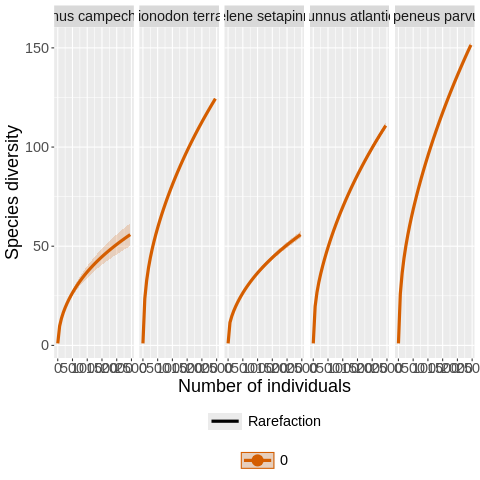

In [9]:
%%R
ggiNEXT(inext_out,
        type = 1,
        se = T,
        facet.var = "Assemblage")

---
## Phylogenetically Informed Alpha Diversity

### Build the Tree

In [ ]:
%%R
if(!file.exists(str_c(here::here(),
                      'intermediate_files/zotu_tree.rds',
                      sep = '/'))){
  zotu_tree <- DNAMultipleAlignment(zotu_sequences) %>%
    msa::msaConvert("phangorn::phyDat") %>%
    fasta2tree(n_bootstraps = tree_bootstraps,
               threshold_bootstraps = floor(tree_bootstraps / 2),
               model_ml = tree_evolutionary_model)
}

if(nzchar(Sys.getenv("COLAB")) &
   file.exists(str_c(here::here(),
                              'intermediate_files/zotu_tree.rds',
                              sep = '/'))){
  zotu_tree <- read_rds(str_c(here::here(),
                              'intermediate_files/zotu_tree.rds',
                              sep = '/'))
}

          JC 915 -45652.17 93134.33 96562.11 
        JC+I 916 -44525.71 90883.42 94314.94 
     JC+G(4) 916 -39259.46 80350.92 83782.44 
   JC+G(4)+I 917 -39210.46 80254.92 83690.18 
[1] "The best version of the  JC  evolutionary model is: JC+G(4)+I"
Optimized evolutionary model parameters:
 optBf = TRUE 
 optQ = TRUE 
 optInv = TRUE 
 optGamma = TRUE 


In [ ]:
%%R
#Plot tree TODO

---
### Phylogenetic Diversity

In [ ]:
%%R
abundance_phylogeny <- match.phylo.comm(midpoint(zotu_tree$tree),
                                        select(predator_gut_contents,
                                               sample_id, starts_with('Zotu')) %>%
                                          column_to_rownames('sample_id'))

faiths_diversity <- pd(abundance_phylogeny$comm,
                       abundance_phylogeny$phy,
                       include.root = TRUE) %>%
  as_tibble(rownames = 'sample_id')

sample_pd <- predator_gut_contents %>%
  select(-starts_with('Zotu')) %>%
  mutate(phylogenetic_distance = mpd(abundance_phylogeny$comm,
                                     cophenetic.phylo(abundance_phylogeny$phy),
                                     abundance.weighted = FALSE)) %>%
  left_join(faiths_diversity,
            by = 'sample_id')

In [ ]:
rename_metrics <- as_labeller(c("PD" = "Faith's Diversity",
                                "phylogenetic_distance" = "Phylogenetic Distance"))
sample_pd %>%
  select(-SR) %>%
  left_join(predator_taxonomy,
            by = c('predator_species_name' = 'species')) %>%
  pivot_longer(cols = c('phylogenetic_distance', 'PD'),
               names_to = 'metric',
               values_to = 'value') %>%
  filter(!is.na(value)) %>%
  ggplot(aes(y = predator_species_name,
             x = value)) +
  stat_summary(fun.data = mean_se) +
  facet_grid(class + order ~ metric,
             scales = 'free',
             space = 'free_y',
             switch = 'both',
             labeller = labeller(metric = rename_metrics)) +
  labs(x = NULL,
       y = 'Predator Species') +
  theme_classic() +
  theme(strip.background = element_blank(),
        strip.text.y.left = element_text(angle = 0),
        strip.placement = 'outside',
        panel.background = element_rect(colour = 'black'),
        axis.text.y = element_text(face = 'italic'))

---
## Hierarchical Alpha Diversity - without Phylogenetic Information

In [ ]:
%%R
sampling_hierarchy <- predator_gut_contents %>%
  select(-starts_with('Zotu')) %>%
  mutate(trophic_level = "predator",
         stomach_id = str_extract(sample_id, "\\d+")) %>%
  distinct(trophic_level, predator_species_name,
           stomach_id, pcr_id = sample_id) %>%
  t() %>%
  as.matrix()

idip_abundance <- select(predator_gut_contents,
       sample_id, starts_with('Zotu')) %>%
  column_to_rownames('sample_id') %>%
  t()


IDIP(abun = idip_abundance,
     struc = sampling_hierarchy)

---
## Hierarchical Alpha Diversity - with Phylogenetic Information

In [ ]:
%%R
zotu_tree$tree$node.label <- str_c('node', 1:length(zotu_tree$tree$node.label))

iDIP.phylo(abun = idip_abundance,
           struc = sampling_hierarchy,
           tree = write.tree(zotu_tree$tree))

---
## Save Results


In [ ]:
%%R
storage_dir <- if_else(nzchar(Sys.getenv("COLAB")), persistent_directory, here::here())
dir.create(str_c(storage_dir, 'intermediate_files', sep = '/'), showWarnings = FALSE)

write_rds(inext_out,
          str_c(storage_dir,
                'intermediate_files/inext_out.rds',
                sep = '/'))

write_rds(zotu_tree,
          str_c(storage_dir,
                'intermediate_files/zotu_tree.rds',
                sep = '/'))

write_csv(sample_pd,
          str_c(storage_dir,
                'intermediate_files/phylogenetic_alpha_diversity.csv',
                sep = '/'))

In [ ]:
#Cleanly unmount Google Drive
drive.flush_and_unmount()